In [1]:
import pandas as pd
import scipy
import numpy as np
from scipy import stats, special

import tensorflow as tf
print(tf.__version__)
sess = tf.InteractiveSession()

import tfnb

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

1.0.0


# Hyperparameters

In [2]:
N_z = 50  # Latent variables
N_h = 100 # Neurons in non-final hidden layer(s)
N_bottleneck = 50 # Neurons in final hidden layer

# Data

In [3]:
# Data
x_array = np.array(pd.read_csv("x.csv"))
y_array = np.array(pd.read_csv("y.csv"))
site_array = (np.array(pd.read_csv("site.csv"))) - 1 # Zero-indexing versus R's one-indexing
obs_array = (np.array(pd.read_csv("obs.csv"))) - 1   # Zero-indexing

# Sizes
N_x = x_array.shape[1]
N_y = y_array.shape[1]

N_s = int(np.max(site_array[:,1])) + 1 # Include zero as a column
N_o = int(np.max(obs_array[:,1])) + 1  # Include zero as a column
N_rows = x_array.shape[0]

N = tf.placeholder(tf.int32, shape=[]) # Minibatch size
Y = tf.placeholder(tf.float32, shape=[None, N_y], name = "abundance") # Response variables
X = tf.placeholder(tf.float32, shape=[None, N_x], name = "environment") # Predictor variables
SO = tf.sparse_placeholder(tf.float32, shape=[None, N_s + N_o], name = "sites-observers") # Random effect design matrix; sites then observers
training = tf.placeholder(tf.bool, shape=[]) # Are we in training mode or test mode?

# Layer 0: calculate random effects & concatenate with X

I'm doing this part manually because of sparseness of the `SO` matrix.  A higher-level way to do this probably exists using one-hot features or something similar.

In [4]:
with tf.variable_scope("latent"):
    # Declare variables for layer 0
    W0_mu = tfnb.make_weights(N_s + N_o,N_z)
    W0_sigma = tfnb.make_weights(N_s + N_o,N_z)
    b0_mu = tf.Variable(tf.zeros(N_z))
    b0_sigma = tf.Variable(0.25 * tf.ones(N_z)) 

    # Sample from latent density (Z)
    mu0 = tf.sparse_tensor_dense_matmul(SO,W0_mu) + b0_mu
    sigma0 = tf.nn.softplus(tf.sparse_tensor_dense_matmul(SO,W0_sigma) + b0_sigma)
    epsilon = tf.random_normal(tf.shape(mu0))
    Z = mu0 + sigma0 * epsilon

# Define layer 1's inputs with X and Z
XZ = tf.concat([X,Z], 1)

# Hidden layers

In [5]:
# Feed forward
H1 = tf.layers.dense(XZ, 
                     units=N_h, 
                     activation=tf.nn.elu,
                     kernel_initializer=tf.contrib.layers.xavier_initializer(),
                     kernel_regularizer = tf.contrib.layers.l2_regularizer(0.01),
                     name="layer1")
H1_normalized = tf.contrib.layers.layer_norm(inputs=H1)
H2 = tf.layers.dense(H1_normalized, 
                     units=N_bottleneck, 
                     activation=tf.nn.elu,
                     kernel_initializer=tf.contrib.layers.xavier_initializer(),
                     kernel_regularizer = tf.contrib.layers.l2_regularizer(0.01),
                     name="layer2")
H2_normalized = tf.contrib.layers.layer_norm(inputs=H2)
HN = H2_normalized

# Output layer

In [6]:
def mu_initializer(*args, **kwargs):
    out = 1.5 * np.log(np.mean(y_array,axis=0)) + 1
    return out
def size_initializer(*args, **kwargs):
    out = scipy.special.logit(np.mean(y_array!=0, axis=0)) / 2.0
    return out
def zi_p_initializer(*args, **kwargs):
    out = scipy.special.logit((np.mean(y_array == 0, axis=0))) / 2.0 - 1.0
    return out

nb_mu = tf.layers.dense(HN,
                        units=N_y,
                        activation=tf.nn.softplus,
                        kernel_initializer=tf.contrib.layers.xavier_initializer(),
                        kernel_regularizer = tf.contrib.layers.l2_regularizer(0.2),
                        bias_initializer = mu_initializer,
                        name="negbin-mean")
nb_size = tf.layers.dense(HN,
                          units=N_y,
                          activation=tf.nn.softplus,
                          kernel_initializer=tf.contrib.layers.xavier_initializer(),
                          kernel_regularizer = tf.contrib.layers.l2_regularizer(1.0),
                          bias_initializer = size_initializer,
                          name="negbin-size")
zi_p = tf.layers.dense(HN,
                       units = N_y,
                       activation=tf.nn.sigmoid,
                       kernel_initializer=tf.contrib.layers.xavier_initializer(),
                       kernel_regularizer = tf.contrib.layers.l2_regularizer(1.0),
                       bias_initializer = zi_p_initializer,
                       name="zero-inflation-prob")

# Switch to N,p parameterization for negative binomial
with tf.variable_scope("negbin-prob"):
    nb_p = nb_size / (nb_mu + nb_size)

# Loss & Optimizer

In [7]:
# For fitting loop
rows = np.arange(y_array.shape[0])
n_steps = 0.
t = tf.placeholder(dtype=tf.float32)

class minibatcher(object):
    def __init__(self, nrow):
        self.nrow = nrow
        self.epochs = 0
        self.pointer = 0
        self.order = np.arange(nrow)
        np.random.shuffle(self.order)
    def get_rows(self, n):
        if (n+self.pointer < self.nrow):
            out = self.order[self.pointer + np.arange(n)]
            self.pointer += n
            return out
        else:
            # This is suboptimal because it throws out anything at the end
            # of the epoch that doesn't divide evenly into `n`
            np.random.shuffle(self.order)
            self.pointer = 0
            self.epochs += 1
            return self.get_rows(n)

mb = minibatcher(N_rows)
            
def make_minibatch(n,is_training):
    if n==N_rows:
        rows = np.arange(N_rows)
    else:
        rows = mb.get_rows(n)
    
    # Coordinates of nonzero entries in sparse design matrix.
    # one site and one observer per row
    i = np.concatenate((np.arange(n), np.arange(n)))
    j = np.concatenate((site_array[rows,1], N_s + obs_array[rows,1]))

    return {X:x_array[rows,:], 
           Y:y_array[rows,:], 
           SO:(np.vstack((i,j)).transpose(), [1] * (2 * n), [n, N_s + N_o]), 
           N:n, 
           t:n_steps,
           training:is_training}
def full_feed():
    return make_minibatch(N_rows,False)


with tf.variable_scope("lossses"):
    prediction_loss = -tf.reduce_sum(tfnb.zi_nbinom_ll(Y, nb_size, nb_p, zi_p))

    # Put a prior on negative binomial's "p" and the zero-inflation parameter, 
    # which both cause numerical problems at 0 or 1
    prior_loss = tfnb.gaussian_loss(tfnb.logit(nb_p), 0, 10, clip=0.1) +\
                    tfnb.gaussian_loss(tfnb.logit(zi_p), 0, 10, clip=0.1) +\
                    tf.reduce_sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
        
    variational_loss = tfnb.kl(mu0, sigma0)
    
    # Don't pay too much for the KL/entropy term until a few thousand iterations in, when
    # the network has started to settle down a bit.
    loss = prediction_loss +\
            prior_loss +\
            variational_loss# * tf.nn.sigmoid((t / 5000. - 5))

# Epsilon is a fudge factor that makes Adam treat the gradients as more noisy than they 
# actually are, which can be important if the gradients are often zero and the sparseness
# stuff isn't working?
adam = tf.train.AdamOptimizer(epsilon=1e-02);
train_step = adam.minimize(loss);

In [8]:
# Session incantations 
init = tf.global_variables_initializer()
sess.run(init)

# Save output for tensorboard
train_writer = tf.summary.FileWriter('./train', sess.graph)
train_writer.close()

# Model-fitting loop

In [27]:
# Fit the model
n = 32

for i in range(1000000):
    if n_steps % 1000 == 0:
        raw_losses = sess.run([prediction_loss, prior_loss, variational_loss, loss], 
                              feed_dict=full_feed())
        print(np.round([loss / N_rows for loss in raw_losses], 4))
    sess.run(train_step, feed_dict=make_minibatch(n,True))
    n_steps += 1
print(n_steps)

[  1.84817800e+02   1.48300000e-01   5.22210000e+00   1.90188200e+02]
[  1.84733600e+02   1.48400000e-01   5.26010000e+00   1.90142000e+02]
[  1.84701800e+02   1.48000000e-01   5.27410000e+00   1.90123900e+02]
[  1.84706500e+02   1.60200000e-01   5.25490000e+00   1.90121600e+02]


KeyboardInterrupt: 

# Downstream analyses

0.082273871

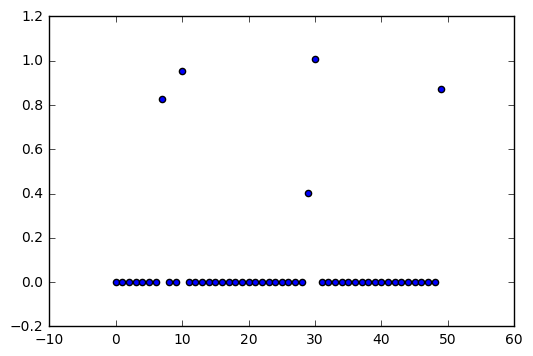

In [28]:
mus, sigmas = sess.run((mu0, sigma0), feed_dict=make_minibatch(N_rows, False))
plt.scatter(range(N_z), np.mean(mus**2, axis = 0));
np.var(mus)

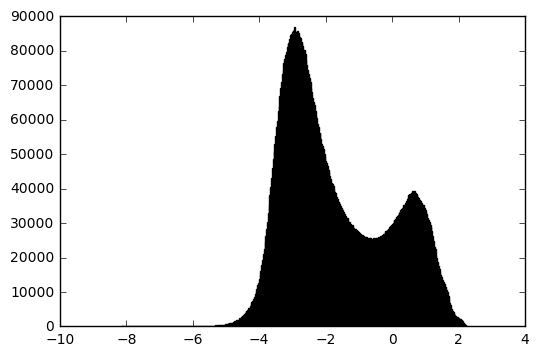

In [29]:
plt.hist(np.log10(np.ndarray.flatten(sess.run(nb_mu, feed_dict=full_feed()))), bins = "fd");

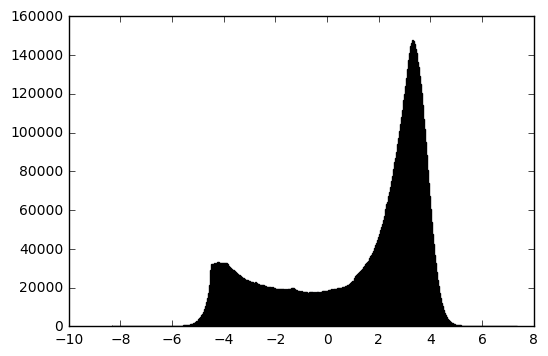

In [30]:
plt.hist(sess.run(tfnb.logit(zi_p), feed_dict=full_feed()).flatten(), bins = "fd");

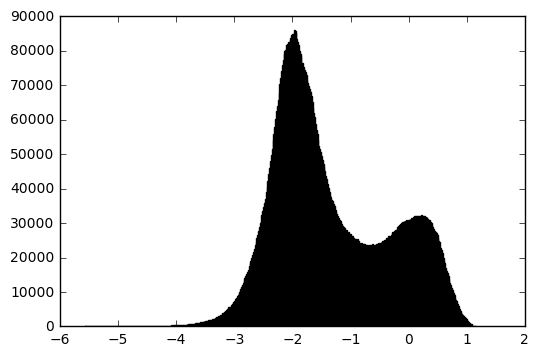

In [31]:
plt.hist(np.log10(sess.run(nb_size, feed_dict=full_feed()).flatten()), bins = "fd");

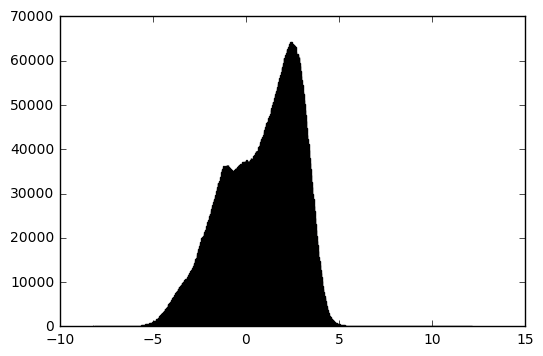

In [32]:
plt.hist(scipy.special.logit(sess.run(nb_p, feed_dict=full_feed()).flatten()), bins = "fd");

In [33]:
#print(np.sqrt(np.mean(sess.run(tf.square(W0_mu)))))
#print(np.sqrt(np.mean(sess.run(tf.square(W0_sigma)))))
#print(np.sqrt(np.mean(sess.run(tf.square(WN_mu)))))
#print(np.sqrt(np.mean(sess.run(tf.square(WN_size)))))
#print(np.sqrt(np.mean(sess.run(tf.square(WN_zi_p)))))

In [34]:
#plt.scatter(np.log(np.mean(y_array, axis=0) + 1), 
#            bN_mu.eval());

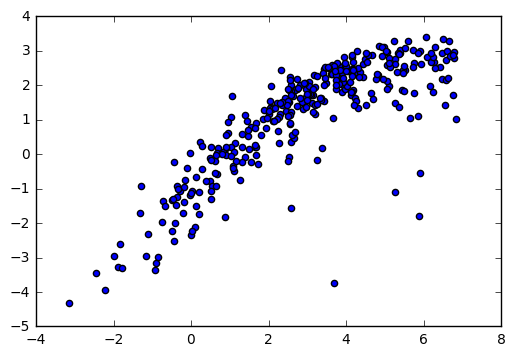

In [35]:
with tf.variable_scope("zero-inflation-prob", reuse=True):
    plt.scatter(scipy.special.logit((np.mean(y_array == 0, axis=0))), 
                tf.get_variable("bias").eval())

In [36]:


#all_mu, all_zip = sess.run((nb_mu, zi_p), feed_dict=full_feed)()
#np.savetxt("mu.csv", all_mu, delimiter=",")
#np.savetxt("zip.csv", all_zip, delimiter=",")

In [37]:
print(n_steps)

122586.0


In [38]:
tf.get_collection(tf.GraphKeys.WEIGHTS)

[]

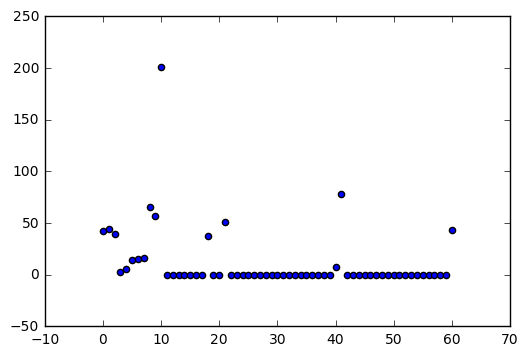

In [39]:
with tf.variable_scope("layer1", reuse=True):
    plt.scatter(range(N_z + N_x), np.sum(tf.get_variable("kernel").eval()**2, axis=1))

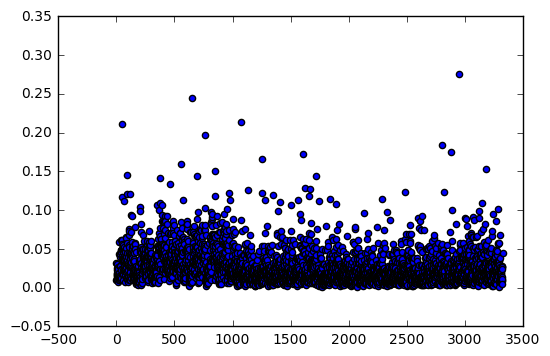

In [40]:
plt.scatter(range(N_s + N_o),
            np.var(sess.run(W0_mu, feed_dict=full_feed()), axis=1));

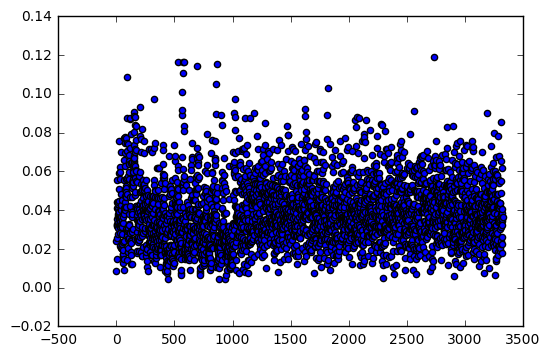

In [41]:
plt.scatter(range(N_s + N_o),
            np.var(sess.run(W0_sigma, feed_dict=full_feed()), axis=1));

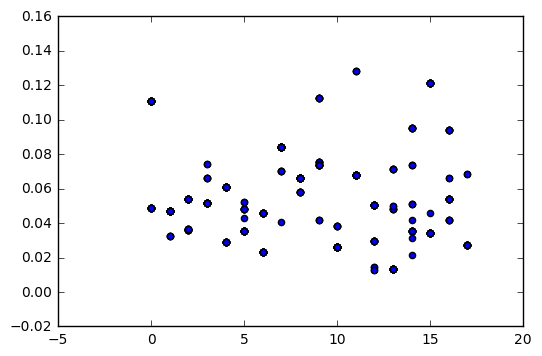

In [42]:
plt.scatter(site_array[range(500),1], 
            np.mean(sess.run(mu0, feed_dict=full_feed())**2, 1)[range(500)])

In [43]:
tf.nn.sigmoid((n_steps / 5000. - 5)).eval()

1.0

In [44]:
np.arange(32).size

32